<a href="https://www.kaggle.com/code/marlonferrari/backtest-em-aloca-o-de-portf-lio-de-a-es?scriptVersionId=141102197" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Backtest em Alocação de Portfólio de Ações
#### Notebook originado do projeto
https://www.kaggle.com/code/onyedikachiudeh/portfolio-assets-allocation/notebook

# Intro
Nesta demo, iremos simular a alocação de $ 1 milhão de dólares em ações da Bolsa Americana. Partindo do princípio que um modelo de montagem de carteira tenha sido executado, as ações escolhidas foram 9.
Em seguida, ocorrerá a distribuição do investimento entre as 9 ações. Em nosso exemplo, distribuiremos pesos aleatórios para fins de demonstração, entretanto, esta tarefa deverá ser também executada por um modelo de otimização prévio.

# Objetivo
Verificar se dada a escolha da carteira das 9 ações e seus respectivos pesos de investimento trouxeram retornos positivos, concluindo ser um fundo viável de aplicação.

## 1. IMPORT DA VISUALIZAÇÃO DE DADOS

In [1]:
import pandas as pd
#evitando notação científica nos valores
pd.options.display.float_format = '{:.2f}'.format

from scipy import stats
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Visualização dinâmica
from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
cf.go_offline()

## 2. CARREGAMENTO DOS DADOS
#### Neste ponto, devemos assumir que um outro modelo tenha escolhido as ações previamente

In [2]:
# Read the stock data file
stock_df = pd.read_csv('../input/ml-prediction/stock.csv', index_col='Date', parse_dates=True)
stock_df.head()


,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
Date,,,,,,,,,
2012-01-12,60.20,75.51,30.12,12.13,175.93,180.55,28.25,313.64,1295.50
2012-01-13,59.97,74.60,30.07,12.35,178.42,179.16,22.79,311.33,1289.09
2012-01-17,60.67,75.24,30.25,12.25,181.66,180.00,26.60,313.12,1293.67
2012-01-18,61.30,75.06,30.33,12.73,189.44,181.07,26.81,315.27,1308.04
2012-01-19,61.11,75.56,30.42,12.80,194.45,180.52,26.76,318.59,1314.50


## 3. VISUALIZAÇÃO DAS COTAÇÕES

In [3]:
stock_df.iplot(title='Cotações de Fechamento por Dia')

## 4. NORMALIZANDO OS DADOS
#### Dividir cada valor pelo valor da primeira linha (mais antiga), provendo uma escala normalizada

In [4]:
normalized_data = stock_df/stock_df.iloc[0,:]
normalized_data

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
Date,,,,,,,,,
2012-01-12,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2012-01-13,1.00,0.99,1.00,1.02,1.01,0.99,0.81,0.99,1.00
2012-01-17,1.01,1.00,1.00,1.01,1.03,1.00,0.94,1.00,1.00
2012-01-18,1.02,0.99,1.01,1.05,1.08,1.00,0.95,1.01,1.01
2012-01-19,1.02,1.00,1.01,1.06,1.11,1.00,0.95,1.02,1.01
...,...,...,...,...,...,...,...,...,...
2020-08-05,7.31,2.31,0.99,1.38,18.22,0.69,52.57,4.70,2.57
2020-08-06,7.57,2.28,0.99,1.52,18.33,0.70,52.73,4.78,2.59
2020-08-07,7.38,2.25,1.00,1.57,18.00,0.69,51.42,4.76,2.59


In [5]:
normalized_data.iplot(title = 'Cotações de Fechamento por Dia - Normalizado')

## 5. Criando os pesos para a carteira
#### Distribuir uma % diferente para cada ação representa um passo importante

In [6]:
#42 para reprodução dos resultados
np.random.seed(42)

# Cria um vetor de números aleatórios entre 0 e 1
# 9 é a quantidade de ações que temos
weights = np.array(np.random.random(9))

# Rebalanceia os pesos para fechar em 100% (1)
weights = weights / np.sum(weights) 
#exibe os pesos de cada ação
for stock, weight in zip(normalized_data.columns, weights):
    print(stock, '>>', round(weight,2)*100, '%')

AAPL >> 8.0 %
BA >> 21.0 %
T >> 16.0 %
MGM >> 13.0 %
AMZN >> 3.0 %
IBM >> 3.0 %
TSLA >> 1.0 %
GOOG >> 19.0 %
sp500 >> 13.0 %


In [7]:
# Substitui o dataset principal pelo normalizado
# o copy cria dois diferentes, em vez de apenas passar uma referência
df_portfolio = normalized_data.copy()
df_portfolio

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
Date,,,,,,,,,
2012-01-12,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2012-01-13,1.00,0.99,1.00,1.02,1.01,0.99,0.81,0.99,1.00
2012-01-17,1.01,1.00,1.00,1.01,1.03,1.00,0.94,1.00,1.00
2012-01-18,1.02,0.99,1.01,1.05,1.08,1.00,0.95,1.01,1.01
2012-01-19,1.02,1.00,1.01,1.06,1.11,1.00,0.95,1.02,1.01
...,...,...,...,...,...,...,...,...,...
2020-08-05,7.31,2.31,0.99,1.38,18.22,0.69,52.57,4.70,2.57
2020-08-06,7.57,2.28,0.99,1.52,18.33,0.70,52.73,4.78,2.59
2020-08-07,7.38,2.25,1.00,1.57,18.00,0.69,51.42,4.76,2.59


## 6. Comprando as ações na proporção dos pesos
#### Iremos comprar $1 milhão

In [8]:
monetary = 1_000_000

In [9]:
df_portfolio = df_portfolio * weights
df_portfolio = df_portfolio * monetary
df_portfolio 

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
Date,,,,,,,,,
2012-01-12,83355.34,211585.12,162908.06,133233.74,34722.55,34717.18,12926.73,192770.83,133780.45
2012-01-13,83042.80,209035.21,162637.62,135650.18,35213.99,34449.90,10428.33,191347.18,133118.52
2012-01-17,84010.10,210828.54,163611.18,134551.80,35853.45,34611.42,12171.72,192446.30,133591.48
2012-01-18,84882.44,210324.17,164043.87,139824.04,37388.96,34817.17,12267.81,193771.98,135075.41
2012-01-19,84613.42,211725.21,164530.65,140592.90,38377.76,34711.41,12244.93,195811.01,135742.50
...,...,...,...,...,...,...,...,...,...
2020-08-05,609602.34,488346.62,161447.72,183649.47,632563.01,24122.24,679520.50,905704.14,343643.83
2020-08-06,630870.89,482518.29,161393.64,202761.32,636504.40,24251.07,681607.05,921985.31,345852.67
2020-08-07,615417.98,476409.77,162367.19,209022.12,625147.97,24028.02,664735.95,918537.33,346071.60


In [10]:
# criando a coluna de valor financeiro total alocado no dia
df_portfolio['valor alocado dia em_$'] = df_portfolio.sum(axis=1)
df_portfolio

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500,valor alocado dia em_$
Date,,,,,,,,,,
2012-01-12,83355.34,211585.12,162908.06,133233.74,34722.55,34717.18,12926.73,192770.83,133780.45,1000000.00
2012-01-13,83042.80,209035.21,162637.62,135650.18,35213.99,34449.90,10428.33,191347.18,133118.52,994923.74
2012-01-17,84010.10,210828.54,163611.18,134551.80,35853.45,34611.42,12171.72,192446.30,133591.48,1001676.00
2012-01-18,84882.44,210324.17,164043.87,139824.04,37388.96,34817.17,12267.81,193771.98,135075.41,1012395.84
2012-01-19,84613.42,211725.21,164530.65,140592.90,38377.76,34711.41,12244.93,195811.01,135742.50,1018349.78
...,...,...,...,...,...,...,...,...,...,...
2020-08-05,609602.34,488346.62,161447.72,183649.47,632563.01,24122.24,679520.50,905704.14,343643.83,4028599.87
2020-08-06,630870.89,482518.29,161393.64,202761.32,636504.40,24251.07,681607.05,921985.31,345852.67,4087744.64
2020-08-07,615417.98,476409.77,162367.19,209022.12,625147.97,24028.02,664735.95,918537.33,346071.60,4041737.93


## 7. Calculando o retorno diário
A fórmula é bem simples:
(dia atual / dia anterior) - 1
* Referência: https://proeducacional.com/ead/curso-preparatorio-cfg-modulo-i/capitulos/metodos-quantitativos/aulas/resumo-cfg-metodos-quantitativos/

Existe aqui uma estratégia importante: devemos sempre comparar o dia atual com seu anterior. Como fazemos isso em pandas? Precisamos deslocar (shift) a coluna de "valor alocado" em 1.
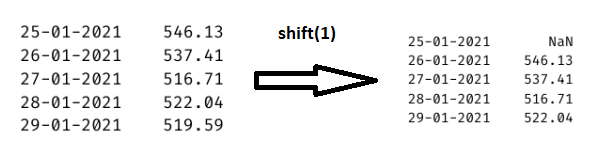
*  Referência: https://datascienceparichay.com/article/pandas-shift-column-values-up-or-down/

In [11]:
# Calculando o retorno diário 
#fórmula: (dia atual / dia anterior) - 1
# o fillna é para que o primeiro dia não seja nulo (pois seu valor deve ser 0)
df_portfolio['retorno diario %'] = ((df_portfolio['valor alocado dia em_$'] / df_portfolio['valor alocado dia em_$'].shift(1)) -1).fillna(0) * 100 # em %
df_portfolio

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500,valor alocado dia em_$,retorno diario %
Date,,,,,,,,,,,
2012-01-12,83355.34,211585.12,162908.06,133233.74,34722.55,34717.18,12926.73,192770.83,133780.45,1000000.00,0.00
2012-01-13,83042.80,209035.21,162637.62,135650.18,35213.99,34449.90,10428.33,191347.18,133118.52,994923.74,-0.51
2012-01-17,84010.10,210828.54,163611.18,134551.80,35853.45,34611.42,12171.72,192446.30,133591.48,1001676.00,0.68
2012-01-18,84882.44,210324.17,164043.87,139824.04,37388.96,34817.17,12267.81,193771.98,135075.41,1012395.84,1.07
2012-01-19,84613.42,211725.21,164530.65,140592.90,38377.76,34711.41,12244.93,195811.01,135742.50,1018349.78,0.59
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-05,609602.34,488346.62,161447.72,183649.47,632563.01,24122.24,679520.50,905704.14,343643.83,4028599.87,1.17
2020-08-06,630870.89,482518.29,161393.64,202761.32,636504.40,24251.07,681607.05,921985.31,345852.67,4087744.64,1.47
2020-08-07,615417.98,476409.77,162367.19,209022.12,625147.97,24028.02,664735.95,918537.33,346071.60,4041737.93,-1.13


## 9. Visualizando as oscilações do portfólio

In [12]:
df_portfolio['retorno diario %'].iplot(title = 'Retorno Diário do Portfólio')

In [13]:
# exibe as ações individuais do portfolio
# -2 exclui as colunas de valores que criamos
df_portfolio[df_portfolio.columns[:-2]].iplot()

## 10. Distribuição das oscilações do Portfólio
Esta parte é fundamental para interpretação dos resultados. Por meio do histograma, vemos a frequência com que nossos dados se encontram, provendo o entendimento dos intervalos de nosso portfólio. 

In [14]:
df_portfolio['retorno diario %'].iplot(kind='hist', title = 'Distribuição dos resultados diários')

### Percebemos que nossa maior frequência ocorre em 0-0.2, explicando que, na maioria dos dias, fechamos quase zerados 

## 11. Calculando o retorno do Portfólio
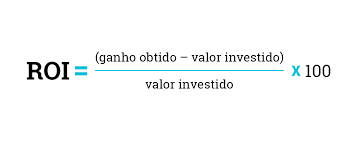

In [15]:
#qual foi o total alocado no último dia de aplicação?
ganho_obtido = df_portfolio['valor alocado dia em_$'][-1]
valor_investido = monetary #1 milhão
ROI = ((ganho_obtido - valor_investido)/valor_investido)*100
print('O ROI do Portfólio é de ',round(ROI),'%')

O ROI do Portfólio é de  303.0 %


## 12. Calculando a volatilidade do Portfólio
#### Uma métrica importante é saber se houve muita instabilidade na aquisição deste ROI. Para isto usamos o desvio padrão:
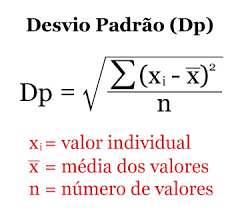

#### Por meio desta medida de dispersão, esperamos que haja o valor mais baixo possível, uma vez que esperamos baixa volatilidade:
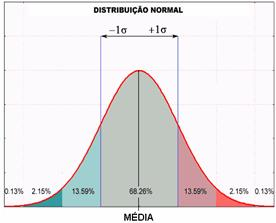

In [16]:
desvio_padrao = df_portfolio['retorno diario %'].std()
print('O Desvio-Padrão é de ', round(desvio_padrao,2))

O Desvio-Padrão é de  1.31


## 13. Medindo o retorno médio por dia

In [17]:
media_retorno_dia = df_portfolio['retorno diario %'].mean()
print('Retorno médio por dia: ', round(media_retorno_dia,2))

Retorno médio por dia:  0.07
